# No dependency introduction to learned optimizers in JAX

This notebook contains a self contained implementation of learned optimizers in JAX.
It is minimal in the hopes that it is easier to follow and give readers a better understanding of what is involved. First we start with some background describing what learned optimizer are. We begin the implementation by implementing a simple MLP and train it with a hand designed optimizer. We then introduce a simple learned optimizer and discuss multiple ways to meta-train the weights of this learned optimizers including gradients, and evolution strategies.

The design ideas and patterns are the same as that used by [`learned_optimization`](https://github.com/google/learned_optimization), but greatly stripped down and simplified.

In [ ]:
import jax
import jax.numpy as jnp
import tensorflow_datasets as tfds
import matplotlib.pylab as plt
import numpy as onp
import functools
import os

## What is a learned optimizer?

Learned optimizers are machine learning models which themselves optimize other machine learning models.

To understand what exactly this means, consider first a simple hand designed optimizer: SGD. We can write the update equation as a single function of both parameter values, $x$, and gradients $\nabla l$ computed on some loss $l$.

$$U_{sgd}(x, \nabla l; \alpha) = - \alpha \nabla l $$

This update can be applied us our next iterate:

$$x' = x + U_{sgd}(x, \nabla l; \alpha)$$

This update rule is simple, effective, and widely used. Can we do better?

Framed in this way, this algorithm is simply a function. One idea to improve training is to switch out this hand designed function with a learned function parameterized by some set of weights, $\theta$:

$$U(x, \nabla l; \theta) = \text{NN}(x, \nabla l; \theta)$$

We call the weights of the optimizer, $\theta$, the meta-parameters, or outer-parameters. The weights this optimizer is optimizing we refer to as the inner-parameters, or simply parameters.

Now given this more flexible form, how do we set a particular value of the learned optimizer weights so that the learned optimizer "performs well"? To do this, we must first define what it means to perform well. In standard optimization, this could mean find some low loss solution after applying the optimizer many times. In machine learning, this could be finding a solution which generalizes. This objective / measurement of performance of the learned optimizer often goes by the name of a meta-loss, or outer loss.

With this metric in hand, we can **optimize** the weights of the learned optimizer with respect to this meta-loss. If we have a flexible enough set of weights, and can solve this optimization problem, we will be left with a performant optimizer!


In this notebook, we first start by defining the type of problem we seek our optimizer to perform well on. Next, we introduce optimizers, followed learned optimizers. Next we define our meta-objective, or our measurement of how well our optimizers perform. Finally, we discuss a variety of techniques, and tricks for meta-training including gradient based, evolutionary strategies based, and by leveraging truncations.

## The inner problem

We seek to train a learned optimizer to perform well on some task. In this demo notebook, we will define our task to be a single MLP trained on resized Fashion Mnist.

### Data iterators
Data iterators are pretty standard, so we will not reinvent the wheel and use tensorflow datasets to create a python iterator which yields batches of data.

To keep meta-training fast, we will be working with with images resized to 8x8.

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteMV51N8/fashion_mnist-train.tfrecord*...:   0…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteMV51N8/fashion_mnist-test.tfrecord*...:   0%…

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


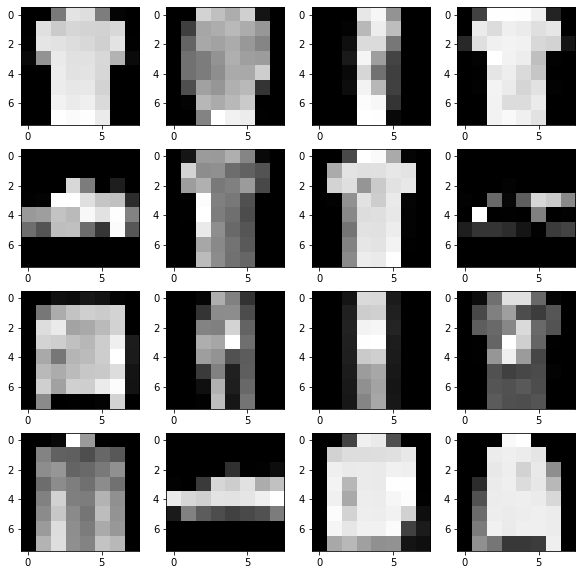

In [ ]:
import tensorflow as tf

ds = tfds.load("fashion_mnist", split="train")


def resize_and_scale(batch):
  batch["image"] = tf.image.resize(batch["image"], (8, 8)) / 255.
  return batch


ds = ds.map(resize_and_scale).cache().repeat(-1).shuffle(
    64 * 10).batch(128).prefetch(5)
data_iterator = ds.as_numpy_iterator()
batch = next(data_iterator)
fig, axs = plt.subplots(4, 4, figsize=(10, 10))
for ai, a in enumerate(axs.ravel()):
  a.imshow(batch["image"][ai][:, :, 0], cmap="gray")

input_size = onp.prod(batch["image"].shape[1:])

### Inner problem loss function & initialization

Next, we must define the inner problem with which we seek to train.
One important note here is no parameters are stored in the task itself! See [this](https://jax.readthedocs.io/en/latest/jax-101/07-state.html) jax tutorial for more information on this.

Our task will have 2 methods -- an init which constructs the initial values of the weights, and a loss which applies the MLP, and returns the average cross entropy loss.

In [ ]:
class MLPTask:

  def init(self, key):
    key1, key2 = jax.random.split(key)
    w0 = jax.random.normal(key1, [input_size, 128]) * 0.02
    w1 = jax.random.normal(key2, [128, 10]) * 0.02
    b0 = jnp.zeros([128])
    b1 = jnp.ones([10])
    return (w0, b0, w1, b1)

  def loss(self, params, batch):
    data = batch["image"]
    data = jnp.reshape(data, [data.shape[0], -1])
    w0, b0, w1, b1 = params
    logits = jax.nn.relu(data @ w0 + b0) @ w1 + b1
    labels = jax.nn.one_hot(batch["label"], 10)
    vec_loss = -jnp.sum(labels * jax.nn.log_softmax(logits), axis=-1)
    return jnp.mean(vec_loss)


task = MLPTask()
key = jax.random.PRNGKey(0)
params = task.init(key)
task.loss(params, batch)

Array(2.3029995, dtype=float32)

### Inner training with SGD

With our newly defined model, let's train it with SGD.

100%|██████████| 1000/1000 [00:07<00:00, 138.92it/s]


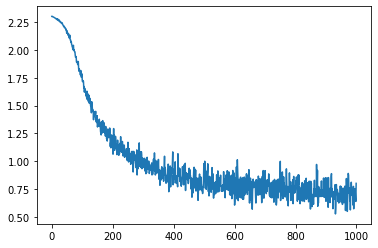

In [ ]:
from tqdm import tqdm

value_grad_fn = jax.jit(jax.value_and_grad(task.loss))
lr = 0.1

losses = []
params = task.init(key)
# get from environment variable so this notebook can be automatically tested.
num_steps = int(os.environ.get("LOPT_TRAIN_LENGTH", 1000))
for i in tqdm(range(num_steps)):
  batch = next(data_iterator)
  loss, grads = value_grad_fn(params, batch)
  params = [p - lr * g for p, g in zip(params, grads)]
  losses.append(loss)
plt.plot(losses)

## Optimizers
SGD is all fine and good, but it is often useful to abstract away the specific update rule. This abstraction has two methods: An init, which setups up the initial optimizer state, and an update which uses this state and gradients to produce some new state.

In the case of SGD, this state is just the parameter values.

In [ ]:
class SGD:

  def __init__(self, lr):
    self.lr = lr

  def init(self, params):
    return (params,)

  def update(self, opt_state, grads):
    return (tuple([p - self.lr * g for p, g in zip(opt_state[0], grads)]),)

Instead of inlining SGD, we can now use our optimizer class.

100%|██████████| 1000/1000 [00:01<00:00, 543.83it/s]


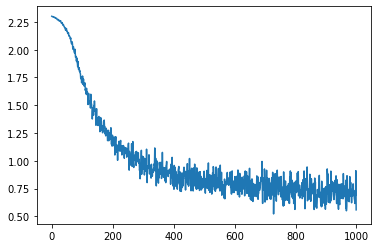

In [ ]:
losses = []
opt = SGD(0.1)
opt_state = opt.init(task.init(key))

num_steps = int(os.environ.get("LOPT_TRAIN_LENGTH", 1000))
for i in tqdm(range(num_steps)):
  batch = next(data_iterator)
  loss, grads = value_grad_fn(opt_state[0], batch)
  opt_state = opt.update(opt_state, grads)
  losses.append(loss)
plt.plot(losses)

Now, let's define some other optimizers. Momentum makes use of an additional accumulator variable. We can define it as follows.

In [ ]:
class Momentum:

  def __init__(self, lr, decay=0.9):
    self.lr = lr
    self.decay = decay

  def init(self, params):
    return (params, [jnp.zeros_like(p) for p in params])

  def update(self, state, grads):
    params, momentum = state
    momentum = [m * self.decay + self.lr * g for m, g in zip(momentum, grads)]
    params = [p - m for p, m in zip(params, momentum)]
    return (params, momentum)

We can use this in our same training loop again. Here, the parameters are stored in the 0th entry of opt_state.

100%|██████████| 1000/1000 [00:03<00:00, 272.53it/s]


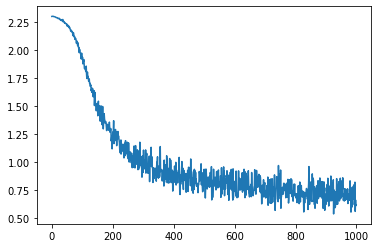

In [ ]:
opt = Momentum(0.01)
params = task.init(key)
opt_state = opt.init(params)
del params

losses = []
num_steps = int(os.environ.get("LOPT_TRAIN_LENGTH", 1000))
for i in tqdm(range(num_steps)):
  batch = next(data_iterator)
  loss, grads = value_grad_fn(opt_state[0], batch)
  opt_state = opt.update(opt_state, grads)
  losses.append(loss)
plt.plot(losses)

And finally, we can implement Adam.

In [ ]:
class Adam:

  def __init__(self, lr, beta1=0.9, beta2=0.999, epsilon=1e-8):
    self.lr = lr
    self.beta1 = beta1
    self.beta2 = beta2
    self.epsilon = epsilon

  def init(self, params):
    return (tuple(params), jnp.asarray(0),
            tuple([jnp.zeros_like(p) for p in params]),
            tuple([jnp.zeros_like(p) for p in params]))

  @functools.partial(jax.jit, static_argnums=(0,))
  def update(self, state, grads):
    params, iteration, momentum, rms = state
    iteration += 1
    momentum = tuple([
        m * self.beta1 + (1 - self.beta1) * g for m, g in zip(momentum, grads)
    ])
    rms = tuple([
        v * self.beta2 + (1 - self.beta2) * (g**2) for v, g in zip(rms, grads)
    ])
    mhat = [m / (1 - self.beta1**iteration) for m in momentum]
    vhat = [v / (1 - self.beta2**iteration) for v in rms]
    params = tuple([
        p - self.lr * m / (jnp.sqrt(v) + self.epsilon)
        for p, m, v in zip(params, mhat, vhat)
    ])
    return (params, iteration, momentum, rms)

## Learned optimizers

A learned optimizer is simply an optimizer which is itself some function of meta-parameters. The actual function can be anything ranging from more fixed form, to more exotic with the meta-parameters encoding neural network weights.

### Per parameter learned optimizers
The family of learned optimizer we will explore in this notebook is "per parameter". What this means, is that the update function operates on each parameter independently.

In our case, the learned optimizer will operate on the parameter value, the gradient value, and momentum. These values get fed into a neural network. This neural network produces 2 outputs: $a$, $b$. These outputs are combined to produce a change in the inner parameters:

$$\Delta w = 0.001 \cdot a \cdot \text{exp}(0.001 \cdot b)$$

We use this formulation, as opposed to simply outputting a direct value, as empirically it is easier to meta-train.

Choosing input parameterizations, and output parameterizations varies across learned optimizer architecture and paper.

In [ ]:
class LOpt:

  def __init__(self, decay=0.9):
    self.decay = decay
    self.hidden_size = 64

  def init_meta_params(self, key):
    """Initialize the learned optimizer weights -- in this case the weights of

    the per parameter mlp.
    """
    key1, key2 = jax.random.split(key)
    input_feats = 3  # parameter value, momentum value, and gradient value

    # the optimizer is a 2 hidden layer MLP.
    w0 = jax.random.normal(key1, [input_feats, self.hidden_size])
    b0 = jnp.zeros([self.hidden_size])

    w1 = jax.random.normal(key2, [self.hidden_size, 2])
    b1 = jnp.zeros([2])
    return (w0, b0, w1, b1)

  def initial_inner_opt_state(self, meta_params, params):
    # The inner opt state contains the parameter values, and the momentum values.
    momentum = [jnp.zeros_like(p) for p in params]
    return tuple(params), tuple(momentum)

  @functools.partial(jax.jit, static_argnums=(0,))
  def update_inner_opt_state(self, meta_params, inner_opt_state, inner_grads):
    "Perform 1 step of learning using the learned optimizer." ""
    params, momentum = inner_opt_state

    # compute momentum
    momentum = [
        m * self.decay + (g * (1 - self.decay))
        for m, g in zip(momentum, inner_grads)
    ]

    def predict_step(features):
      """Predict the update for a single ndarray."""
      w0, b0, w1, b1 = meta_params
      outs = jax.nn.relu(features @ w0 + b0) @ w1 + b1
      # slice out the last 2 elements
      scale = outs[..., 0]
      mag = outs[..., 1]
      # Compute a step as follows.
      return scale * 0.01 * jnp.exp(mag * 0.01)

    out_params = []
    for p, m, g in zip(params, momentum, inner_grads):
      features = jnp.asarray([p, m, g])
      # transpose to have features dim last. The MLP will operate on this,
      # and treat the leading dimensions as a batch dimension.
      features = jnp.transpose(features, list(range(1, 1 + len(p.shape))) + [0])

      step = predict_step(features)
      out_params.append(p - step)

    return tuple(out_params), tuple(momentum)

We can now randomly init the meta-parameters a few times and apply it to our target task and see what we get.

Unsurprisingly, our randomly initialized learned optimizer doesn't do all that well at training our target problem. Many of them even diverge / nan.

100%|██████████| 1000/1000 [00:01<00:00, 896.49it/s]


Text(0, 0.5, 'inner loss')

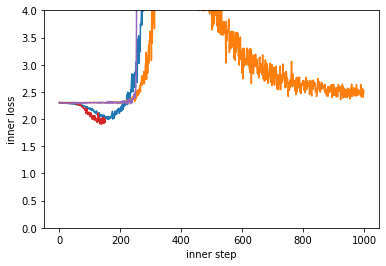

In [ ]:
lopt = LOpt()
for i in range(5):
  losses = []
  key = jax.random.PRNGKey(i)
  meta_params = lopt.init_meta_params(key)

  key = jax.random.PRNGKey(0)
  params = task.init(key)
  opt_state = lopt.initial_inner_opt_state(meta_params, params)

  num_steps = int(os.environ.get("LOPT_TRAIN_LENGTH", 1000))
  for i in tqdm(range(num_steps)):
    batch = next(data_iterator)
    loss, grads = value_grad_fn(opt_state[0], batch)
    opt_state = lopt.update_inner_opt_state(meta_params, opt_state, grads)
    losses.append(loss)
  plt.plot(losses)
plt.ylim(0, 4)
plt.xlabel("inner step")
plt.ylabel("inner loss")

## Meta-loss: Measuring the performance of the learned optimizer.

Now we must define our measurement of performance for our learned optimizers. For this, we will define a meta_loss function. This function takes in as inputs the weights of the meta-parameters, initializes the weights of the inner-problem, and performs some number of steps of inner-training using a learned optimizer and the passed in meta-parameters. Each step we return the training loss, and use this average loss as the meta-loss. Depending on what we use, e.g. different unroll lengths, or different objectives (such as returning just loss at the end of training, or validation loss) we will get different behaving optimizers.

In [ ]:
lopt = LOpt()

key = jax.random.PRNGKey(i)
meta_params = lopt.init_meta_params(key)


def get_batch_seq(seq_len):
  batches = [next(data_iterator) for _ in range(seq_len)]
  # stack the data to add a leading dim.
  return {
      "image": jnp.asarray([b["image"] for b in batches]),
      "label": jnp.asarray([b["label"] for b in batches])
  }


@jax.jit
def meta_loss(meta_params, key, sequence_of_batches):

  def step(opt_state, batch):
    loss, grads = value_grad_fn(opt_state[0], batch)
    opt_state = lopt.update_inner_opt_state(meta_params, opt_state, grads)
    return opt_state, loss

  params = task.init(key)
  opt_state = lopt.initial_inner_opt_state(meta_params, params)
  # Iterate N times where N is the number of batches in sequence_of_batches
  opt_state, losses = jax.lax.scan(step, opt_state, sequence_of_batches)

  return jnp.mean(losses)


key = jax.random.PRNGKey(0)
meta_loss(meta_params, key, get_batch_seq(10))

Array(2.2996302, dtype=float32)

## Meta-training with Gradients
Meta-training means training the weights of the learned optimizer to perform well in some setting. There are a lot of ways to do this optimization problem. We will run through a few different examples here.


One of the most conceptually simple way to meta-train is to do so with gradients. In particular, the gradients of the meta-loss with respect to the meta-parameters.

Te will use our meta-loss and `jax.value_and_grad` to compute gradients. For this simple example, we will use the average training loss over 10 applications of the learned optimizer as our meta-loss.

In [ ]:
key = jax.random.PRNGKey(0)
meta_value_grad_fn = jax.jit(jax.value_and_grad(meta_loss))
loss, meta_grad = meta_value_grad_fn(meta_params, key, get_batch_seq(10))

We can use this meta-gradient, with Adam to update the weights of our learned optimizer.

In [ ]:
meta_opt = Adam(0.001)
key = jax.random.PRNGKey(0)
meta_params = lopt.init_meta_params(key)
meta_opt_state = meta_opt.init(meta_params)
meta_losses = []

num_steps = int(os.environ.get("LOPT_TRAIN_LENGTH", 1000))
for i in tqdm(range(num_steps)):
  data = get_batch_seq(15)
  key1, key = jax.random.split(key)
  loss, meta_grad = meta_value_grad_fn(meta_opt_state[0], key1, data)
  meta_losses.append(loss)
  if i % 20 == 0:
    print(onp.mean(meta_losses[-20:]))
  meta_opt_state = meta_opt.update(meta_opt_state, meta_grad)

  0%|          | 0/1000 [00:00<?, ?it/s]

2.299093


  3%|▎         | 29/1000 [00:03<00:49, 19.80it/s]

2.2724967


  5%|▌         | 52/1000 [00:03<00:22, 41.83it/s]

2.2121644


  7%|▋         | 67/1000 [00:03<00:18, 51.09it/s]

2.128191


  9%|▉         | 91/1000 [00:04<00:14, 64.77it/s]

2.0316706


 12%|█▏        | 115/1000 [00:04<00:12, 69.40it/s]

1.9628208


 13%|█▎        | 131/1000 [00:04<00:12, 70.09it/s]

1.9149338


 16%|█▌        | 155/1000 [00:05<00:11, 70.76it/s]

1.8878136


 17%|█▋        | 171/1000 [00:05<00:11, 71.12it/s]

1.8606306


 19%|█▊        | 187/1000 [00:05<00:11, 71.60it/s]

1.8398087


 21%|██        | 210/1000 [00:05<00:11, 66.68it/s]

1.8101333


 23%|██▎       | 232/1000 [00:06<00:11, 67.00it/s]

1.8007933


 25%|██▌       | 253/1000 [00:06<00:11, 67.32it/s]

1.791983


 27%|██▋       | 269/1000 [00:06<00:10, 69.80it/s]

1.7796475


 29%|██▉       | 293/1000 [00:07<00:10, 70.09it/s]

1.7715666


 31%|███       | 309/1000 [00:07<00:09, 71.13it/s]

1.7750299


 33%|███▎      | 331/1000 [00:07<00:10, 66.58it/s]

1.7557526


 34%|███▍      | 345/1000 [00:07<00:10, 59.83it/s]

1.7437779


 37%|███▋      | 369/1000 [00:08<00:14, 43.71it/s]

1.7347147


 39%|███▊      | 387/1000 [00:08<00:16, 36.82it/s]

1.7331371


 40%|████      | 404/1000 [00:09<00:16, 35.57it/s]

1.7282101


 43%|████▎     | 427/1000 [00:10<00:15, 37.52it/s]

1.7112093


 45%|████▍     | 449/1000 [00:10<00:15, 36.18it/s]

1.7139533


 47%|████▋     | 466/1000 [00:11<00:15, 34.30it/s]

1.7171104


 49%|████▊     | 487/1000 [00:11<00:13, 37.81it/s]

1.6970507


 51%|█████▏    | 513/1000 [00:12<00:08, 58.30it/s]

1.710029


 53%|█████▎    | 528/1000 [00:12<00:07, 63.37it/s]

1.6836144


 55%|█████▌    | 551/1000 [00:12<00:06, 69.87it/s]

1.695987


 57%|█████▋    | 573/1000 [00:12<00:06, 69.87it/s]

1.6621269


 60%|█████▉    | 595/1000 [00:13<00:05, 68.58it/s]

1.695771


 61%|██████    | 610/1000 [00:13<00:05, 71.04it/s]

1.674165


 63%|██████▎   | 634/1000 [00:13<00:05, 71.22it/s]

1.6877661


 65%|██████▌   | 650/1000 [00:14<00:05, 69.73it/s]

1.6795002


 67%|██████▋   | 672/1000 [00:14<00:04, 70.39it/s]

1.6581398


 69%|██████▉   | 688/1000 [00:14<00:04, 71.49it/s]

1.6638515


 71%|███████   | 710/1000 [00:14<00:04, 68.32it/s]

1.6534135


 73%|███████▎  | 733/1000 [00:15<00:03, 68.66it/s]

1.6411779


 76%|███████▌  | 755/1000 [00:15<00:03, 68.64it/s]

1.6549915


 77%|███████▋  | 770/1000 [00:15<00:03, 69.49it/s]

1.6322807


 79%|███████▉  | 791/1000 [00:16<00:03, 65.42it/s]

1.637566


 81%|████████  | 812/1000 [00:16<00:02, 66.50it/s]

1.6322839


 83%|████████▎ | 833/1000 [00:16<00:02, 67.20it/s]

1.6191399


 85%|████████▍ | 847/1000 [00:16<00:02, 64.78it/s]

1.637179


 87%|████████▋ | 869/1000 [00:17<00:01, 66.54it/s]

1.6278843


 89%|████████▉ | 892/1000 [00:17<00:01, 65.88it/s]

1.6204841


 91%|█████████▏| 913/1000 [00:17<00:01, 66.67it/s]

1.634121


 94%|█████████▎| 935/1000 [00:18<00:00, 66.63it/s]

1.6096674


 95%|█████████▌| 950/1000 [00:18<00:00, 66.00it/s]

1.6175604


 97%|█████████▋| 972/1000 [00:18<00:00, 68.13it/s]

1.6130764


 99%|█████████▉| 994/1000 [00:19<00:00, 68.79it/s]

1.611722


100%|██████████| 1000/1000 [00:19<00:00, 51.87it/s]


Text(0, 0.5, 'meta-loss')

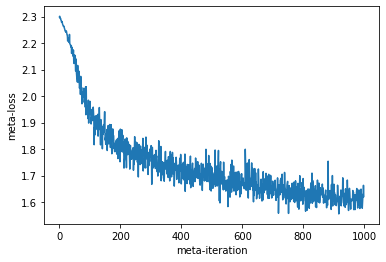

In [ ]:
plt.plot(meta_losses)
plt.xlabel("meta-iteration")
plt.ylabel("meta-loss")

Our meta-loss is decreasing which means our learned optimizer is learning to perform well on the meta-loss which means it is able to optimize our inner problem. Let's see what it learned to do by applying it to some target problem.

100%|██████████| 20/20 [00:00<00:00, 916.15it/s]


Text(0, 0.5, 'loss')

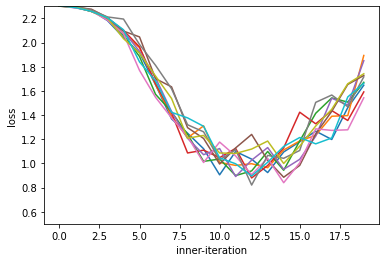

In [ ]:
meta_params = meta_opt_state[0]

for j in range(10):
  losses = []
  key = jax.random.PRNGKey(j)
  params = task.init(key)
  opt_state = lopt.initial_inner_opt_state(meta_params, params)

  for i in tqdm(range(20)):
    batch = next(data_iterator)
    loss, grads = value_grad_fn(opt_state[0], batch)
    opt_state = lopt.update_inner_opt_state(meta_params, opt_state, grads)
    losses.append(loss)
  plt.plot(losses)
  plt.ylim(0.5, 2.3)
plt.xlabel("inner-iteration")
plt.ylabel("loss")

We can see our optimizer works, and is able to optimize for these first 10 steps.

Теперь давайте добавим в фичи оптимайзера второй градиент и номер шага

In [ ]:
import numpy as np



class MyLOpt:

  def __init__(self, decay=0.9):
    self.decay = decay
    self.hidden_size = 64

  def init_meta_params(self, key):
    """Initialize the learned optimizer weights -- in this case the weights of

    the per parameter mlp.
    """
    key1, key2 = jax.random.split(key)
    input_feats = 4  # parameter value, momentum value, gradient, second gradient, and step num value

    # the optimizer is a 2 hidden layer MLP.
    w0 = jax.random.normal(key1, [input_feats, self.hidden_size])
    b0 = jnp.zeros([self.hidden_size])

    w1 = jax.random.normal(key2, [self.hidden_size, 2])
    b1 = jnp.zeros([2])
    return (w0, b0, w1, b1)

  def initial_inner_opt_state(self, meta_params, params):
    # The inner opt state contains the parameter values, and the momentum values.
    momentum = [jnp.zeros_like(p) for p in params]
    return tuple(params), tuple(momentum)

  @functools.partial(jax.jit, static_argnums=(0,))
  def update_inner_opt_state(self, meta_params, inner_opt_state, inner_grads, step_num):
    "Perform 1 step of learning using the learned optimizer." ""
    params, momentum = inner_opt_state

    # compute momentum
    momentum = [
        m * self.decay + (g * (1 - self.decay))
        for m, g in zip(momentum, inner_grads)
    ]

    def predict_step(features):
      """Predict the update for a single ndarray."""
      w0, b0, w1, b1 = meta_params
      outs = jax.nn.relu(features @ w0 + b0) @ w1 + b1
      # slice out the last 2 elements
      scale = outs[..., 0]
      mag = outs[..., 1]
      # Compute a step as follows.
      return scale * 0.01 * jnp.exp(mag * 0.01)

    out_params = []
    i = 0
    for p, m, g in zip(params, momentum, inner_grads):
      features = jnp.asarray([p, m, g, jnp.full_like(g, step_num)])
      # transpose to have features dim last. The MLP will operate on this,
      # and treat the leading dimensions as a batch dimension.
      features = jnp.transpose(features, list(range(1, 1 + len(p.shape))) + [0])

      step = predict_step(features)
      out_params.append(p - step)
      i += 1

    return tuple(out_params), tuple(momentum)

In [ ]:
value_grad_fn = jax.jit(jax.value_and_grad(task.loss))


In [ ]:
value_grad2_fn = jax.jit(jax.hessian(task.loss))


In [ ]:
lopt = MyLOpt()

key = jax.random.PRNGKey(i)
meta_params = lopt.init_meta_params(key)

def get_batch_seq(seq_len):
  batches = [next(data_iterator) for _ in range(seq_len)]
  # stack the data to add a leading dim.
  return {
      "image": jnp.asarray([b["image"] for b in batches]),
      "label": jnp.asarray([b["label"] for b in batches])
  }

step_num = 0

@jax.jit
def meta_loss(meta_params, key, sequence_of_batches):
  global step_num
  step_num = 0

  def step(opt_state, batch):
    global step_num
    step_num += 1
    loss, grads = value_grad_fn(opt_state[0], batch)
    opt_state = lopt.update_inner_opt_state(meta_params, opt_state, grads, 0)
    return opt_state, loss

  params = task.init(key)
  opt_state = lopt.initial_inner_opt_state(meta_params, params)
  # Iterate N times where N is the number of batches in sequence_of_batches
  opt_state, losses = jax.lax.scan(step, opt_state, sequence_of_batches)

  return jnp.mean(losses)


key = jax.random.PRNGKey(0)
meta_loss(meta_params, key, get_batch_seq(10))

Array(2.2942626, dtype=float32)

2.3000255


  2%|▎         | 25/1000 [00:03<00:56, 17.31it/s]

2.2688186


  4%|▍         | 45/1000 [00:04<00:34, 28.02it/s]

2.1732774


  6%|▋         | 65/1000 [00:04<00:29, 31.95it/s]

2.023335


  9%|▉         | 92/1000 [00:05<00:18, 48.45it/s]

1.9118707


 11%|█         | 110/1000 [00:05<00:17, 52.26it/s]

1.862887


 13%|█▎        | 128/1000 [00:05<00:16, 54.00it/s]

1.8056568


 15%|█▌        | 152/1000 [00:06<00:15, 54.16it/s]

1.7994617


 17%|█▋        | 170/1000 [00:06<00:15, 53.14it/s]

1.7743965


 19%|█▉        | 188/1000 [00:07<00:14, 54.31it/s]

1.7558897


 21%|██        | 212/1000 [00:07<00:14, 54.98it/s]

1.7227917


 23%|██▎       | 230/1000 [00:07<00:14, 54.41it/s]

1.7222217


 25%|██▍       | 248/1000 [00:08<00:13, 54.58it/s]

1.706137


 27%|██▋       | 266/1000 [00:08<00:13, 54.99it/s]

1.6956766


 35%|███▌      | 350/1000 [00:10<00:12, 53.71it/s]

1.6535667


 37%|███▋      | 368/1000 [00:10<00:11, 53.69it/s]

1.6511881


 39%|███▊      | 386/1000 [00:10<00:11, 52.05it/s]

1.6382462


 41%|████      | 409/1000 [00:11<00:11, 52.34it/s]

1.6362938


 43%|████▎     | 427/1000 [00:11<00:10, 54.59it/s]

1.6275021


 45%|████▌     | 451/1000 [00:12<00:10, 53.97it/s]

1.6203763


 47%|████▋     | 469/1000 [00:12<00:09, 55.14it/s]

1.6241341


 49%|████▊     | 487/1000 [00:12<00:09, 52.34it/s]

1.6099732


 51%|█████     | 511/1000 [00:13<00:09, 53.03it/s]

1.6028652


 53%|█████▎    | 529/1000 [00:13<00:08, 53.17it/s]

1.589364


 55%|█████▍    | 547/1000 [00:13<00:08, 55.71it/s]

1.5899231


 57%|█████▋    | 571/1000 [00:14<00:07, 54.14it/s]

1.5772152


 59%|█████▉    | 589/1000 [00:14<00:07, 53.42it/s]

1.5840787


 61%|██████    | 607/1000 [00:14<00:07, 50.88it/s]

1.5849243


 63%|██████▎   | 626/1000 [00:16<00:18, 19.96it/s]

1.5842026


 64%|██████▍   | 645/1000 [00:17<00:21, 16.56it/s]

1.5776708


 67%|██████▋   | 669/1000 [00:17<00:08, 39.51it/s]

1.5649911


 69%|██████▉   | 688/1000 [00:18<00:09, 33.31it/s]

1.5612738


 71%|███████   | 711/1000 [00:18<00:06, 47.66it/s]

1.5482761


 73%|███████▎  | 729/1000 [00:19<00:05, 51.92it/s]

1.5521458


 75%|███████▍  | 747/1000 [00:19<00:04, 52.48it/s]

1.540279


 77%|███████▋  | 771/1000 [00:20<00:04, 53.46it/s]

1.5403033


 79%|███████▉  | 789/1000 [00:20<00:03, 55.25it/s]

1.5392554


 81%|████████  | 807/1000 [00:20<00:03, 55.83it/s]

1.5375423


 83%|████████▎ | 831/1000 [00:21<00:03, 54.89it/s]

1.5216349


 85%|████████▍ | 849/1000 [00:21<00:02, 55.50it/s]

1.5216478


 87%|████████▋ | 867/1000 [00:21<00:02, 55.09it/s]

1.5285578


 89%|████████▉ | 891/1000 [00:22<00:01, 55.11it/s]

1.525488


 91%|█████████ | 909/1000 [00:22<00:01, 54.72it/s]

1.5254774


 93%|█████████▎| 927/1000 [00:22<00:01, 53.10it/s]

1.5163466


 95%|█████████▌| 951/1000 [00:23<00:00, 53.14it/s]

1.5194527


 97%|█████████▋| 969/1000 [00:23<00:00, 54.34it/s]

1.5061747


 99%|█████████▊| 987/1000 [00:24<00:00, 54.36it/s]

1.5118494


100%|██████████| 1000/1000 [00:24<00:00, 41.16it/s]


Text(0, 0.5, 'meta-loss')

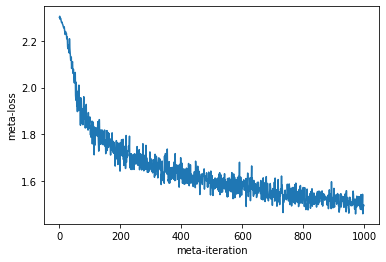

In [ ]:
key = jax.random.PRNGKey(0)
meta_value_grad_fn = jax.jit(jax.value_and_grad(meta_loss))
loss, meta_grad = meta_value_grad_fn(meta_params, key, get_batch_seq(10))

meta_opt = Adam(0.001)
key = jax.random.PRNGKey(0)
meta_params = lopt.init_meta_params(key)
meta_opt_state = meta_opt.init(meta_params)
meta_losses = []

num_steps = int(os.environ.get("LOPT_TRAIN_LENGTH", 1000))
for i in tqdm(range(num_steps)):
  data = get_batch_seq(20)
  key1, key = jax.random.split(key)
  loss, meta_grad = meta_value_grad_fn(meta_opt_state[0], key1, data)
  meta_losses.append(loss)
  if i % 20 == 0:
    print(onp.mean(meta_losses[-20:]))
  meta_opt_state = meta_opt.update(meta_opt_state, meta_grad)

plt.plot(meta_losses)
plt.xlabel("meta-iteration")
plt.ylabel("meta-loss")

100%|██████████| 20/20 [00:00<00:00, 265.93it/s]


Text(0, 0.5, 'loss')

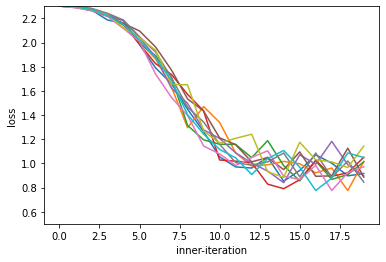

In [ ]:
meta_params = meta_opt_state[0]

for j in range(10):
  losses = []
  key = jax.random.PRNGKey(j)
  params = task.init(key)
  opt_state = lopt.initial_inner_opt_state(meta_params, params)

  for i in tqdm(range(20)):
    batch = next(data_iterator)
    loss, grads = value_grad_fn(opt_state[0], batch)
    opt_state = lopt.update_inner_opt_state(meta_params, opt_state, grads, 0)
    losses.append(loss)
  plt.plot(losses)
  plt.ylim(0.5, 2.3)
plt.xlabel("inner-iteration")
plt.ylabel("loss")

## Vectorization: Speeding up Meta-training

The above example, we are training a single problem instance for 10 iterations, and using this single training to compute meta-gradients. Oftentimes we seek to compute meta-gradients from more than one problem or to average over multiple random initializations / batches of data. To do this, we will leverage `jax.vmap`.

We will define a vectorized meta-loss, which computes the original `meta_loss` function in parallel, then averages the losses. We can then call `jax.value_and_grad` on this function to compute meta-gradients which are the average of these samples.

One big advantage to vectorizing in this way is to make better use of hardware accelerators. When training learned optimizers, we often apply them to small problems for speedy meta-training. These small problems can be a poor fit for the underlying hardware which often consists of big matrix multiplication units. What vectorization does compute multiple of these small problems *at the same time*, which, depending on the details, can be considerably faster.

In [ ]:
def get_vec_batch_seq(vec_size, seq_len):
  batches = [get_batch_seq(seq_len) for _ in range(vec_size)]
  # stack them
  return {
      "image": jnp.asarray([b["image"] for b in batches]),
      "label": jnp.asarray([b["label"] for b in batches])
  }


def vectorized_meta_loss(meta_params, key, sequence_of_batches):
  vec_loss = jax.vmap(
      meta_loss, in_axes=(None, 0, 0))(meta_params, key, sequence_of_batches)
  return jnp.mean(vec_loss)


vec_meta_loss_grad = jax.jit(jax.value_and_grad(vectorized_meta_loss))
vec_sec_batch = get_vec_batch_seq(4, 10)
keys = jax.random.split(key, 4)
loses, meta_grad = vec_meta_loss_grad(meta_params, keys, vec_sec_batch)

And now we can meta-train with this vectorized loss similarly to before.

In [ ]:
meta_opt = Adam(0.001)
key = jax.random.PRNGKey(0)
meta_params = lopt.init_meta_params(key)
meta_opt_state = meta_opt.init(meta_params)
meta_losses = []
num_steps = int(os.environ.get("LOPT_TRAIN_LENGTH", 200))
for i in range(num_steps):
  data = get_vec_batch_seq(8, 10)
  key1, key = jax.random.split(key)
  keys = jax.random.split(key1, 8)
  loss, meta_grad = vec_meta_loss_grad(meta_opt_state[0], keys, data)
  meta_losses.append(loss)
  if i % 20 == 0:
    print(onp.mean(meta_losses[-20:]))
  meta_opt_state = meta_opt.update(meta_opt_state, meta_grad)

2.3015163
2.2858846
2.262492
2.2396119
2.2089443
2.1768482
2.1378422
2.0993867
2.0581489
2.0262241


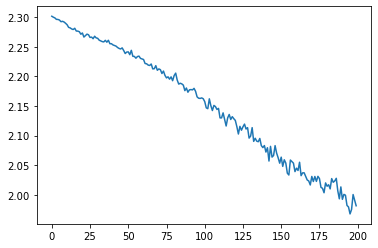

In [ ]:
plt.plot(meta_losses)

## Evolutionary Strategies (ES): Meta-training without meta-gradients
Computing gradients through long optimization procedures can sometimes lead to chaotic dynamics, and result in exploding gradients. See [https://arxiv.org/abs/1810.10180](https://arxiv.org/abs/1810.10180) and [https://arxiv.org/abs/2111.05803](https://arxiv.org/abs/2111.05803) for more info.

An alternative is to leverage black box optimization techniques. A method we found that works well is evolutionary strategies with antithetic samples. This estimator can be thought of as a randomized finite difference. We sample a random direction in the meta-parameters, compute the meta-loss when shifting in this direction, and in the negative of this direction, and move in the direction which lowers the loss. The estimator can be written as:

$$\nabla_\theta = \mathbb{E}_{\epsilon \sim \mathcal{N}(0, I\sigma)} \dfrac{\epsilon}{2 \sigma ^2} (L(\theta + \epsilon) - L(\theta - \epsilon))$$

where $L$ is the meta-loss.

As before, we will construct a vectorized version of these estimators to average over a number of different random directions.

In [ ]:
def antithetic_es_estimate(meta_params, key, seq_of_batches):
  """Compute a ES estimated gradient along a single direction."""
  std = 0.001
  keys = jax.random.split(key, len(meta_params))
  noise = [
      jax.random.normal(keys[i], p.shape) * std
      for i, p in enumerate(meta_params)
  ]
  meta_params_pos = [p + n for p, n in zip(meta_params, noise)]
  meta_params_neg = [p - n for p, n in zip(meta_params, noise)]

  pos_loss = meta_loss(meta_params_pos, key, seq_of_batches)
  neg_loss = meta_loss(meta_params_neg, key, seq_of_batches)

  factor = (pos_loss - neg_loss) / (2 * std**2)
  es_grads = [factor * n for n in noise]
  return (pos_loss + neg_loss) / 2.0, es_grads


@jax.jit
def vec_antithetic_es_estimate(meta_params, keys, vec_seq_batches):
  """Compute a ES estimated gradient along multiple directions."""
  losses, grads = jax.vmap(
      antithetic_es_estimate, in_axes=(None, 0, 0))(meta_params, keys,
                                                    vec_seq_batches)
  return jnp.mean(losses), [jnp.mean(g, axis=0) for g in grads]


keys = jax.random.split(key, 8)
vec_sec_batch = get_vec_batch_seq(8, 10)
loss, es_grads = vec_antithetic_es_estimate(meta_params, keys, vec_sec_batch)

We can use a similar meta-training procedure as before now with this new gradient estimator.

In [ ]:
meta_opt = Adam(0.003)
key = jax.random.PRNGKey(0)
meta_params = lopt.init_meta_params(key)
meta_opt_state = meta_opt.init(meta_params)
meta_losses = []
n_particles = 32

num_steps = int(os.environ.get("LOPT_TRAIN_LENGTH", 200))
for i in range(num_steps):
  data = get_vec_batch_seq(n_particles, 10)
  key1, key = jax.random.split(key)
  keys = jax.random.split(key1, n_particles)
  loss, meta_grad = vec_antithetic_es_estimate(meta_opt_state[0], keys, data)
  meta_losses.append(loss)
  if i % 20 == 0:
    print(onp.mean(meta_losses[-20:]))

  meta_opt_state = meta_opt.update(meta_opt_state, meta_grad)

2.3011694
2.2831185
2.2696424
2.256878
2.246539
2.2384717
2.229327
2.2206445
2.213926
2.2045903


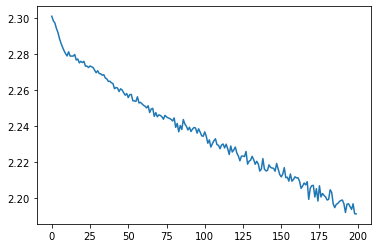

In [ ]:
plt.plot(meta_losses)

## Meta-training with Truncated backprop through time
In the previous meta-training examples, in the meta-loss we always initialized the inner-problem and apply the optimizer for some fixed number of steps.

This is fine for short inner-problem training times, it becomes costly for longer numbers of inner-iterations.
Truncated backprop through time, and more generally truncated meta-training techniques are one solution to this. The core idea is to split up one longer sequence into smaller chunks and compute meta-gradients only within a chunk. This allows one to compute gradients faster -- each chunk we get a gradient estimate, but these methods are generally biased as we ignore how the chunks interact with each other.

The code for this is a bit more involved. First, we need to keep track of each inner problem. In our case, this means keeping track of the inner problems optimizer state, as well as the current training iteration. Next, we must check if we are at the end of an inner-training. We fix the length of the inner training to be 100 for this example. We can then define a function (`short_segment_unroll`) which both progresses training by some number of steps,
and return the loss from that segment.

In [ ]:
def short_segment_unroll(meta_params,
                         key,
                         inner_opt_state,
                         on_iteration,
                         seq_of_batches,
                         inner_problem_length=100):

  def step(scan_state, batch):
    opt_state, i, key = scan_state

    # If we have trained more than 100 steps, reset the inner problem.
    key1, key = jax.random.split(key)
    opt_state, i = jax.lax.cond(
        i >= inner_problem_length, lambda k:
        (lopt.initial_inner_opt_state(meta_params, task.init(k)), 0), lambda k:
        (opt_state, i + 1), key)

    loss, grads = value_grad_fn(opt_state[0], batch)
    opt_state = lopt.update_inner_opt_state(meta_params, opt_state, grads)

    # clip the loss to prevent diverging inner models
    loss = jax.lax.cond(
        jnp.isnan(loss), lambda loss: 3.0, lambda loss: jnp.minimum(loss, 3.0),
        loss)

    return (opt_state, i, key), loss

  (inner_opt_state, on_iteration,
   _), losses = jax.lax.scan(step, (inner_opt_state, on_iteration, key),
                             seq_of_batches)

  return losses, inner_opt_state, on_iteration


inner_opt_state = lopt.initial_inner_opt_state(meta_params, task.init(key))
batch = get_batch_seq(10)

loss, inner_opt_state, on_iteration = short_segment_unroll(
    meta_params, key, inner_opt_state, 0, batch)
on_iteration

DeviceArray(10, dtype=int32, weak_type=True)

Now with this function, we are free to estimate gradients over just this one short unroll rather than the full inner-training. We can use whatever gradient estimator we want -- either ES, or with backprop gradients -- but for now I will show an example with backprop gradients.

As before, we construct a vectorized version of this unroll function, and compute gradients with `jax.value_and_grad`.

In [ ]:
def vec_short_segment_unroll(meta_params,
                             keys,
                             inner_opt_states,
                             on_iterations,
                             vec_seq_of_batches,
                             inner_problem_length=100):
  losses, inner_opt_states, on_iterations = jax.vmap(
      short_segment_unroll,
      in_axes=(None, 0, 0, 0, 0, None))(meta_params, keys, inner_opt_states,
                                        on_iterations, vec_seq_of_batches,
                                        inner_problem_length)
  return jnp.mean(losses), (inner_opt_states, on_iterations)


vec_short_segment_grad = jax.jit(
    jax.value_and_grad(vec_short_segment_unroll, has_aux=True))

We can then use this function to compute meta-gradients. Before doing that though, we must setup the initial state (parameter values and optimizer state) of the problems being trained.

In [ ]:
#num_tasks = 32
num_tasks = 16

key = jax.random.PRNGKey(1)
meta_params = lopt.init_meta_params(key)


def init_single_inner_opt_state(key):
  return lopt.initial_inner_opt_state(meta_params, task.init(key))


keys = jax.random.split(key, num_tasks)
inner_opt_states = jax.vmap(init_single_inner_opt_state)(keys)

# Randomly set the initial iteration to prevent the tasks from running in lock step.
on_iterations = jax.random.randint(key, [num_tasks], 0, 100)

In [ ]:
meta_opt = Adam(0.0001)
meta_opt_state = meta_opt.init(meta_params)

meta_losses = []

num_steps = int(os.environ.get("LOPT_TRAIN_LENGTH", 400))
for i in range(num_steps):
  data = get_vec_batch_seq(num_tasks, 10)
  key1, key = jax.random.split(key)
  keys = jax.random.split(key1, num_tasks)
  (loss, (inner_opt_states, on_iterations)), meta_grad = vec_short_segment_grad(
      meta_opt_state[0], keys, inner_opt_states, on_iterations, data)
  meta_losses.append(loss)
  if i % 20 == 0:
    print(i, onp.mean(meta_losses[-20:]))
  meta_opt_state = meta_opt.update(meta_opt_state, meta_grad)

0 2.3025281
20 2.302613
40 2.302506
60 2.2939959
80 2.228974
100 2.146706
120 2.062469
140 1.9681495
160 1.8850164
180 1.8478796
200 1.8156666
220 1.7869465
240 1.7575241
260 1.7495174
280 1.7104518
300 1.7048458
320 1.6748368
340 1.6512482
360 1.6221116
380 1.5998225


Text(0, 0.5, 'meta-loss')

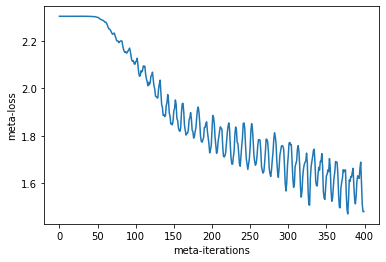

In [ ]:
plt.plot(meta_losses)
plt.xlabel("meta-iterations")
plt.ylabel("meta-loss")

Our meta-loss is going down which is great! There is a periodic behavior to the loss as we are averaging over different positions in inner-training.
For example, if we are averaging more samples from earlier in training, we will have higher loss.


We can now apply our optimizer for 100 steps. We can see that the resulting optimizer optimizes for ~50 steps, and then diverages. This is an indication that meta-training could have been more successful. One can improve this by meta-training for longer, or with different hparams to improve this!

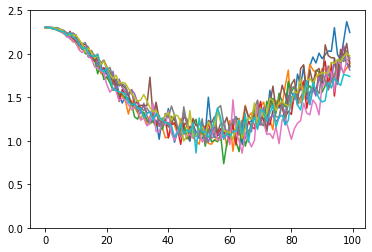

In [ ]:
meta_params = meta_opt_state[0]

for j in range(10):
  losses = []
  key = jax.random.PRNGKey(j)
  params = task.init(key)
  opt_state = lopt.initial_inner_opt_state(meta_params, params)

  num_steps = int(os.environ.get("LOPT_TRAIN_LENGTH", 100))
  for i in range(num_steps):
    batch = next(data_iterator)
    loss, grads = value_grad_fn(opt_state[0], batch)
    opt_state = lopt.update_inner_opt_state(meta_params, opt_state, grads)
    losses.append(loss)
  plt.plot(losses)
  plt.ylim(0.0, 2.5)

## Meta-training truncated ES
Next, instead of meta-training with truncated gradients, we will meta-train with truncated evolution strategies.

In [ ]:
@jax.jit
def vec_short_segment_es(meta_param,
                         keys,
                         inner_opt_state,
                         on_iterations,
                         vec_seq_of_batches,
                         std=0.01):
  # Compute an es estimate on a single inner-problem
  def do_one(meta_param, key, inner_opt_state, on_iteration, seq_of_batches):
    # Sample random noise of the same shape as meta-parameters
    flat_params, struct = jax.tree_util.tree_flatten(meta_param)
    keys = [jax.random.fold_in(key, i) for i in range(len(flat_params))]
    keys = jax.tree_util.tree_unflatten(struct, keys)
    perturbs = jax.tree_util.tree_map(lambda k, v: jax.random.normal(k, v.shape) * std,
                            keys, meta_param)

    # compute positive and negative antithetic samples
    pos_theta = jax.tree_util.tree_map(lambda eps, v: v + eps, perturbs, meta_param)
    neg_theta = jax.tree_util.tree_map(lambda eps, v: v - eps, perturbs, meta_param)

    # Apply both of the antithetic samples
    p_losses, p_opt_state, p_on_iteration = short_segment_unroll(
        pos_theta,
        key,
        inner_opt_state,
        on_iteration,
        seq_of_batches,
        inner_problem_length=30)
    n_losses, n_opt_state, n_on_iteration = short_segment_unroll(
        neg_theta,
        key,
        inner_opt_state,
        on_iteration,
        seq_of_batches,
        inner_problem_length=30)
    p_loss = jnp.mean(p_losses)
    n_loss = jnp.mean(n_losses)

    # estimate gradient
    es_grad = jax.tree_util.tree_map(lambda p: (p_loss - n_loss) * 1 / (2. * std) * p,
                           perturbs)

    return ((p_loss + n_loss) / 2.0, (p_opt_state, p_on_iteration)), es_grad

  (loss, inner_opt_state), es_grad = jax.vmap(
      do_one, in_axes=(None, 0, 0, 0, 0))(meta_param, keys, inner_opt_state,
                                          on_iterations, vec_seq_of_batches)

  # Gradient has an extra batch dimension here from the vmap -- reduce over this.
  return (jnp.mean(loss),
          inner_opt_state), jax.tree_util.tree_map(lambda x: jnp.mean(x, axis=0), es_grad)

In [ ]:
num_tasks = 32

key = jax.random.PRNGKey(1)
inner_opt_state = lopt.initial_inner_opt_state(meta_params, task.init(key))
batch = get_batch_seq(10)

meta_params = lopt.init_meta_params(key)


def init_single_inner_opt_state(key):
  return lopt.initial_inner_opt_state(meta_params, task.init(key))


keys = jax.random.split(key, num_tasks)
inner_opt_states = jax.vmap(init_single_inner_opt_state)(keys)

# Randomly set the initial iteration to prevent the tasks from running in lock step.
on_iterations = jax.random.randint(key, [num_tasks], 0, 30)

In [ ]:
meta_opt = Adam(0.001)
meta_opt_state = meta_opt.init(meta_params)

meta_losses = []

num_steps = int(os.environ.get("LOPT_TRAIN_LENGTH", 400))
for i in range(num_steps):
  data = get_vec_batch_seq(num_tasks, 10)
  key1, key = jax.random.split(key)
  keys = jax.random.split(key1, num_tasks)
  (loss, (inner_opt_states, on_iterations)), meta_grad = vec_short_segment_es(
      meta_opt_state[0], keys, inner_opt_states, on_iterations, data)
  meta_losses.append(loss)
  if i % 20 == 0:
    print(i, onp.mean(meta_losses[-20:]))
  meta_opt_state = meta_opt.update(meta_opt_state, meta_grad)

0 2.3028803
20 2.301912
40 2.2743235
60 2.2011428
80 2.0796442
100 1.9650596
120 1.8779399
140 1.8373306
160 1.8046211
180 1.7904768
200 1.7764364
220 1.7700386
240 1.7758758
260 1.773428
280 1.7594522
300 1.7603681
320 1.7564806
340 1.7545398
360 1.744331
380 1.7509981


Text(0, 0.5, 'meta-loss')

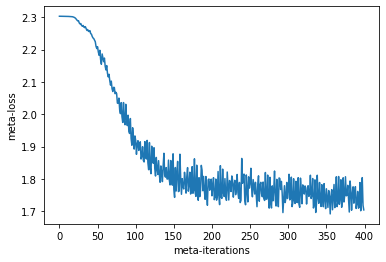

In [ ]:
plt.plot(meta_losses)
plt.xlabel("meta-iterations")
plt.ylabel("meta-loss")

## Meta-training with truncations with less bias: Persistent Evolution Strategies (PES)
When training with truncated evolutionary strategies, as well as truncated backprop through time and truncated evolutionary strategies one cannot compute the effect of one truncated segment, on other truncated segments. This introduces bias when working with longer sequences.

PES is one ES based algorithm to prevent such bias.

In [ ]:
@jax.jit
def vec_short_segment_pes(meta_param,
                          keys,
                          pes_state,
                          vec_seq_of_batches,
                          std=0.01):
  # Compute a pes estimate on a single inner-problem
  def do_one(meta_param, key, pes_state, seq_of_batches):
    accumulator, pos_opt_state, neg_opt_state, on_iteration = pes_state

    # Sample random noise of the same shape as meta-parameters
    flat_params, struct = jax.tree_util.tree_flatten(meta_param)
    keys = [jax.random.fold_in(key, i) for i in range(len(flat_params))]
    keys = jax.tree_util.tree_unflatten(struct, keys)
    perturbs = jax.tree_util.tree_map(lambda k, v: jax.random.normal(k, v.shape) * std,
                            keys, meta_param)

    # compute positive and negative antithetic samples
    pos_theta = jax.tree_util.tree_map(lambda eps, v: v + eps, perturbs, meta_param)
    neg_theta = jax.tree_util.tree_map(lambda eps, v: v - eps, perturbs, meta_param)

    # Apply both of the antithetic samples
    p_losses, pos_opt_state, _ = short_segment_unroll(
        pos_theta,
        key,
        pos_opt_state,
        on_iteration,
        seq_of_batches,
        inner_problem_length=30)
    n_losses, neg_opt_state, next_on_iteration = short_segment_unroll(
        neg_theta,
        key,
        neg_opt_state,
        on_iteration,
        seq_of_batches,
        inner_problem_length=30)

    # estimate gradient. PES works by multipliying loss difference by the sum
    # of previous perturbations.
    new_accum = jax.tree_util.tree_map(lambda a, b: a + b, accumulator, perturbs)
    delta_losses = p_losses - n_losses
    unroll_length = p_losses.shape[0]

    # one unroll could span 2 problems, so we compute 2 different gradients --
    # one as if it was the previous trajectory, and one as if it was a previous
    # unroll and sum them.
    has_finished = (jnp.arange(unroll_length) + on_iteration) > 30

    last_unroll_losses = jnp.mean(delta_losses * (1.0 - has_finished), axis=0)
    new_unroll = jnp.mean(delta_losses * has_finished)

    es_grad_from_accum = jax.tree_util.tree_map(
        lambda p: last_unroll_losses * 1 / (2. * std) * p, new_accum)
    es_grad_from_new_perturb = jax.tree_util.tree_map(
        lambda p: new_unroll * 1 / (2. * std) * p, perturbs)
    es_grad = jax.tree_util.tree_map(lambda a, b: a + b, es_grad_from_accum,
                           es_grad_from_new_perturb)

    # finally, we potentially reset the accumulator to the current perturbation
    # if we finished one trajectory.
    def _switch_one_accum(a, b):
      return jnp.where(has_finished[-1], a, b)

    new_accum = jax.tree_util.tree_map(_switch_one_accum, perturbs, new_accum)

    next_pes_state = (new_accum, pos_opt_state, neg_opt_state,
                      next_on_iteration)

    return ((jnp.mean(p_losses) + jnp.mean(n_losses)) / 2.0,
            next_pes_state), es_grad

  (loss, pes_state), es_grad = jax.vmap(
      do_one, in_axes=(None, 0, 0, 0))(meta_param, keys, pes_state,
                                       vec_seq_of_batches)

  # Gradient has an extra batch dimension here from the vmap -- reduce over this.
  return (jnp.mean(loss),
          pes_state), jax.tree_util.tree_map(lambda x: jnp.mean(x, axis=0), es_grad)

In [ ]:
num_tasks = 32

key = jax.random.PRNGKey(1)
inner_opt_state = lopt.initial_inner_opt_state(meta_params, task.init(key))
batch = get_batch_seq(10)

meta_params = lopt.init_meta_params(key)

# construct the initial PES state which is passed from iteration to iteration
def init_single_inner_opt_state(key):
  return lopt.initial_inner_opt_state(meta_params, task.init(key))
keys = jax.random.split(key, num_tasks)
inner_opt_states = jax.vmap(init_single_inner_opt_state)(keys)
accumulator = jax.tree_util.tree_map(lambda x: jnp.zeros([num_tasks] + list(x.shape)),
                           meta_params)
# Randomly set the initial iteration to prevent the tasks from running in lock step.
on_iterations = jax.random.randint(key, [num_tasks], 0, 30)
pes_state = (accumulator, inner_opt_states, inner_opt_states, on_iterations)

In [ ]:
meta_opt = Adam(0.0003)
meta_opt_state = meta_opt.init(meta_params)

meta_losses = []

num_steps = int(os.environ.get("LOPT_TRAIN_LENGTH", 400))
for i in range(num_steps):
  data = get_vec_batch_seq(num_tasks, 10)
  key1, key = jax.random.split(key)
  keys = jax.random.split(key1, num_tasks)
  (loss, pes_state), meta_grad = vec_short_segment_pes(meta_opt_state[0], keys,
                                                       pes_state, data)
  meta_losses.append(loss)
  if i % 20 == 0:
    print(i, onp.mean(meta_losses[-20:]))
  meta_opt_state = meta_opt.update(meta_opt_state, meta_grad)

0 2.302895
20 2.3025956
40 2.3024507
60 2.3007588
80 2.2814593
100 2.2528963
120 2.221389
140 2.1904716
160 2.1542785
180 2.1154919
200 2.0792098
220 2.0493665
240 2.0263429
260 2.000341
280 1.9719956
300 1.946686
320 1.9295752
340 1.9169009
360 1.8944466
380 1.880933


Text(0, 0.5, 'meta-loss')

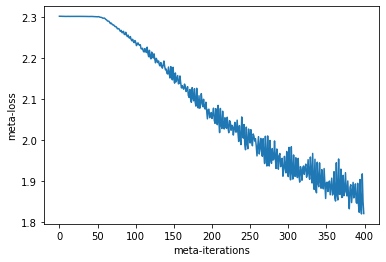

In [ ]:
plt.plot(meta_losses)
plt.xlabel("meta-iterations")
plt.ylabel("meta-loss")

## Exercises
For those curious in getting their feet wet, fork this notebook and try to implement any of the following!

* Modify the meta-loss to meta-train targeting some validation loss rather than train loss.
* Add other features to the learned optimizer such as rolling second moment features (such as adam) or momentums at different timescales.
* Make the per parameter MLP a per parameter RNN.

## Conclusion and relations to the `learned_optimization` package
We hope this notebook gives you an introduction to learned optimizers.
This is an incredibly minimal implementation, and as a result suboptimal in a number of ways.
The `learned_optimization` library was designed based on the patterns used above, but expanded upon to be more general, more scalable, and more fully featured.

The core designs of how to implement these things in jax remain very consistent.
We outline a few of the main differences.


### PyTree all the things
In the above examples, we made use of tuples and lists to store parameters, and opt states. This is simple, but gets unwieldy with more complex structures.
With `learned_optimization` every piece of data is stored as some kind of jax pytree -- oftentimes a dataclass registered as a pytree. These pytree require the use of the [pytree library](https://jax.readthedocs.io/en/latest/pytrees.html).

### Tasks
The task interface is quite similar to what we have shown here. There is one other layer of abstraction in `learned_optimization`, namely `TaskFamily`. In this example, we meta-train on multiple tasks in parallel -- the only difference between these tasks is their random initialization. A `TaskFamily` let's one instead vectorize over other aspects of the problem. Common examples include vectorizing over different kinds of initializations, or different kinds of activation functions.

### Optimizers
The optimizer interface is also basically the same. The main differences being that the learned optimization optimizers can accept additional arguments such as `num_steps` (target number of steps for learning rate schedules and related), jax.PRNGKey for stochastic optimizers, and loss values.

### LearnedOptimizers
In this colab, the learned optimizers and optimizers here have different signatures.
In `learned_optimization` a LearnedOptimizer contains a function of meta-parameters which itself returns an instance of an Optimizer. For example the update can be called as: `lopt.opt_fn(meta_params).update(opt_state, grads)`.

The learned optimizer implemented in this notebook is designed to be simple and easy to follow as opposed to performant / easy to meta-train. `learned_optimization` comes packaged with a number of learned optimizer implementations which will give much better performance.

### Meta-training
This is the biggest divergence. Meta-training algorithms are implemented as subclasses of `GradientEstimator`. These operate internally like the truncated training in that they store state which is passed from iteration to iteration, but are much more general.
They implement 2 functions, one to initialize the state of the inner-problems, and the second to perform updates. This mirrors the 2 functions we needed to write for truncated training.
When applying the meta-gradient updates we make use of a `GradientLearner` class which can be either run on a single or multiple machines.